In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from ase.io.trajectory import Trajectory

from abtem import __version__
print('AbTEM version:',__version__)
from abtem import Potential, PlaneWave, CTF
from abtem.temperature import MDFrozenPhonons
from abtem.noise import poisson_noise
from abtem.mtf import MTF
from abtem.transfer import scherzer_defocus

from skimage.filters import gaussian

AbTEM version: 1.0.0beta24


In [2]:
itraj = Trajectory('trajectory_data/initial.traj')
fptraj = Trajectory('trajectory_data/fp-hot.traj')
fpedgetraj = Trajectory('trajectory_data/fp-hot-edges.traj')
mdtraj = Trajectory('trajectory_data/md-hot.traj')

iconfig = itraj[0]
fpconfigs = fptraj[::100]
fpedgeconfigs = fpedgetraj[::100]
mdconfigs = mdtraj[len(fptraj)+1::100]

print(len(fpconfigs),len(fpedgeconfigs),len(mdconfigs))
fp_phonons = MDFrozenPhonons(fpconfigs)
fpedge_phonons = MDFrozenPhonons(fpedgeconfigs)
md_phonons = MDFrozenPhonons(mdconfigs)

N = 1000
sampling = 0.05
ipotential = Potential(iconfig,
              sampling=sampling,
              gpts=(N,N),
              parametrization='kirkland',
              projection='infinite')
fppotential = Potential(fp_phonons,
              sampling=sampling,
              gpts=(N,N),
              parametrization='kirkland',
              projection='infinite')
fpedgepotential = Potential(fpedge_phonons,
              sampling=sampling,
              gpts=(N,N),
              parametrization='kirkland',
              projection='infinite')
mdpotential = Potential(md_phonons,
              sampling=sampling,
              gpts=(N,N),
              parametrization='kirkland',
              projection='infinite')

25 25 25


In [3]:
wave = PlaneWave(energy=50e3)

In [4]:
iexitwave = wave.multislice(ipotential)
itraj.close()

Potential:   0%|          | 0/31 [00:00<?, ?it/s]

Multislice:   0%|          | 0/31 [00:00<?, ?it/s]

In [5]:
fpexitwave = wave.multislice(fppotential)
fptraj.close()

TDS:   0%|          | 0/25 [00:00<?, ?it/s]

Multislice:   0%|          | 0/31 [00:00<?, ?it/s]

Potential:   0%|          | 0/31 [00:00<?, ?it/s]

In [6]:
fpedgeexitwave = wave.multislice(fpedgepotential)
fpedgetraj.close()

TDS:   0%|          | 0/25 [00:00<?, ?it/s]

Multislice:   0%|          | 0/31 [00:00<?, ?it/s]

Potential:   0%|          | 0/31 [00:00<?, ?it/s]

In [7]:
mdexitwave = wave.multislice(mdpotential)
mdtraj.close()

TDS:   0%|          | 0/25 [00:00<?, ?it/s]

Multislice:   0%|          | 0/31 [00:00<?, ?it/s]

Potential:   0%|          | 0/31 [00:00<?, ?it/s]

Scherzer Defocus: <function scherzer_defocus at 0x7f0906d59b80> Å


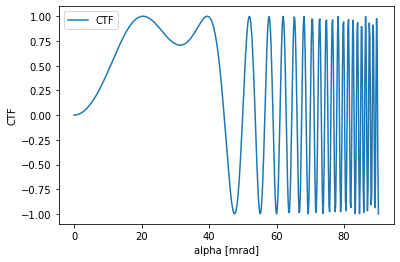

In [8]:
# See coefficients here
# https://abtem.readthedocs.io/en/latest/walkthrough/05_contrast_transfer_function.html
Cs = 8300*10 # Spherical abberation in Å
ctf = CTF(
    Cs=Cs,
    energy = wave.energy
)
ctf.defocus = scherzer_defocus(Cs, wave.energy) # Optimal defocus based on Cs and wavelength
print('Scherzer Defocus: {} Å'.format(scherzer_defocus))

ctf.show(90)
plt.show()

In [9]:
iimagewave = iexitwave.apply_ctf(ctf)
fpimagewave = fpexitwave.apply_ctf(ctf)
fpedgeimagewave = fpedgeexitwave.apply_ctf(ctf)
mdimagewave = mdexitwave.apply_ctf(ctf)

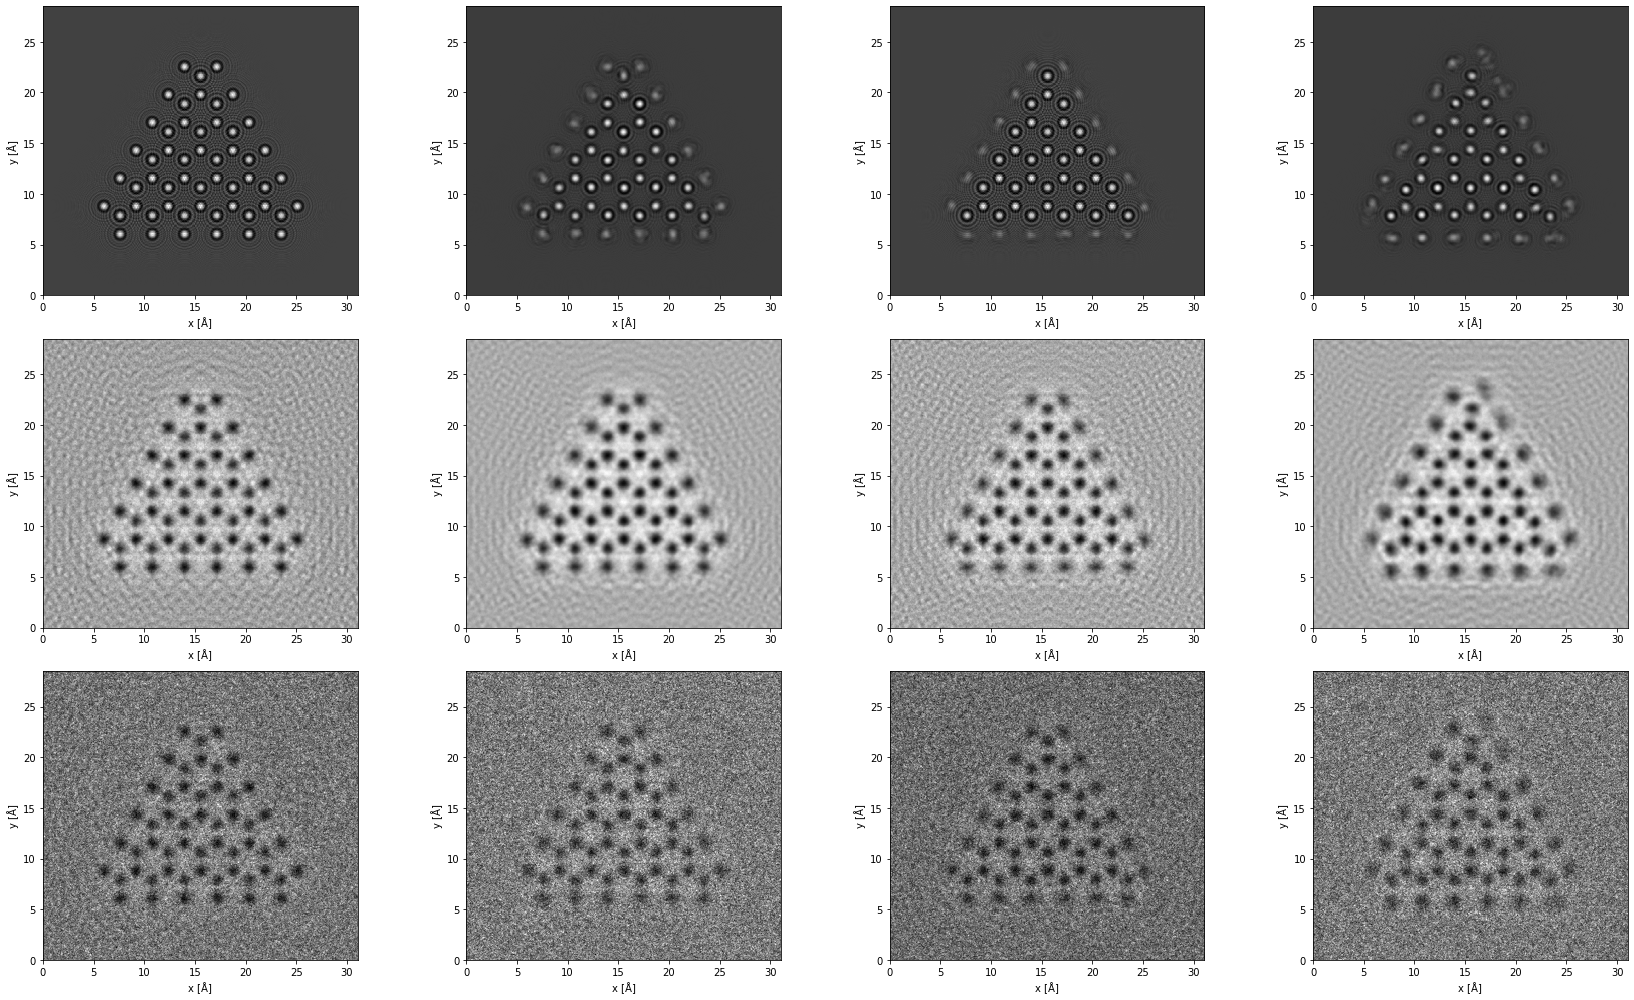

In [10]:
def mtf_func(q, c1, c2, c3):
    return (1 - c1) / ( 1 + (q / c2)**c3 ) + c1

resample = 0.1    # Angstrom/pixel for detector resolution
dose = 1*10**3      # electrons/Angstrom squared for noise
mtf_parameters = {
    'c1': 0.1,
    'c2': 0.13,
    'c3': 1.74
}
blur = 0.1

fig, ax = plt.subplots(figsize=(24.0,14.0),nrows=3,ncols=4)

iexitwave.intensity()[0].show(ax=ax[0,0])
fpexitwave.intensity().mean(0).show(ax=ax[0,1])
fpedgeexitwave.intensity().mean(0).show(ax=ax[0,2])
mdexitwave.intensity().mean(0).show(ax=ax[0,3])
iimagewave.intensity()[0].show(ax=ax[1,0])
fpimagewave.intensity().mean(0).show(ax=ax[1,1])
fpedgeimagewave.intensity().mean(0).show(ax=ax[1,2])
mdimagewave.intensity().mean(0).show(ax=ax[1,3])

for i,measurement_raw in enumerate([ 
                                    iimagewave.intensity(), 
                                    fpimagewave.intensity().mean(0),
                                    fpedgeimagewave.intensity().mean(0),
                                    mdimagewave.intensity().mean(0) ]):
    # Add gaussian blur
    measurement_blur = measurement_raw.squeeze() # Removes 0 dimension (be careful when doing frozen phonon)
    measurement_blur = measurement_blur.gaussian_filter([blur, blur])

    # Add noise to image
    measurement_noise = poisson_noise(measurement_blur, dose)

    # Apply MTF
    img_array = measurement_noise.array
    measurement_MTF = measurement_noise.copy()

    kx = np.fft.fftfreq(img_array.shape[0], d=sampling)*sampling
    ky = np.fft.fftfreq(img_array.shape[1], d=sampling)*sampling
    Kx, Ky = np.meshgrid(kx,ky)
    K = np.sqrt(Kx ** 2 + Ky ** 2)

    new_img_array = np.fft.ifft2((np.fft.fft2(img_array)) * mtf_func(K, **mtf_parameters))
    measurement_MTF.array[:] = new_img_array.real

    # Resample to match experimental
    measurement = measurement_MTF.interpolate(resample)
    measurement.show(ax=ax[2,i])

plt.tight_layout()
plt.show()